## **Import Libraries**

#### **Paper:** https://arxiv.org/pdf/2401.15884

In [1]:
import time, re
from typing import List, TypedDict
from pydantic import BaseModel

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Image

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

### **Load Books**

In [2]:
docs = (
    PyPDFLoader("../../../assets/books/deep_learning.pdf").load() +
    PyPDFLoader("../../../assets/books/hands_on_ml.pdf").load() +
    PyPDFLoader("../../../assets/books/pattern_recognition.pdf").load()
)

- docs length

In [3]:
len(docs)

2123

### **Split Documents into Chunks**

In [4]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

### **Embedding and Indexing**

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)

- **Retriever**

In [6]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [14]:
retrieved_docs = retriever.invoke("Explain the bias–variance tradeoff")

In [16]:
len(retrieved_docs)

4

- **LLM**

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [38]:
class State(TypedDict):
    question: str
    docs: List[Document]

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer: str

In [39]:
def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

- **Sentence-level DECOMPOSER**

In [40]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

In [41]:
context = "\n\n".join(d.page_content for d in retrieved_docs).strip()
# context

In [42]:
decomposed_context = decompose_to_sentences(context)
len(decomposed_context)

26

**FILTER (LLM judge)**

In [43]:
class KeepDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict relevance filter.\n"
        "Return keep=true only if the sentence directly helps answer the question.\n"
        "Use ONLY the sentence. Output JSON only.",
    ),
    (
    "human", "Question: {question}\n\nSentence:\n{sentence}"
    )
])

In [44]:
filter_chain = filter_prompt | llm.with_structured_output(KeepDrop)

- **REFINING (Decompose -> Filter -> Recompose)**

In [45]:
def refine(state: State) -> State:

    q = state["question"]

    # Combine retrieved docs into one context string
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()

    # 1) DECOMPOSITION: context -> sentence strips
    strips = decompose_to_sentences(context)

    # 2) FILTER: keep only relevant strips
    kept: List[str] = []
    
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    # 3) RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [46]:
refined = refine({"question": "Explain the bias–variance tradeoff", "docs": retrieved_docs})

In [49]:
# refined['refined_context']

- **ANSWER GENERATION**

In [50]:
answer_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a helpful ML tutor. Answer ONLY using the provided refined bullets.\n"
        "If the bullets are empty or insufficient, say: 'I don't know based on the provided books.'",
    ),
    (
    "human", "Question: {question}\n\nRefined context:\n{refined_context}"
    ),
])

In [51]:
def generate_answer(state: State) -> State:
    output = (answer_prompt | llm).invoke({
        "question": state["question"], 
        "refined_context": state["refined_context"]
    })

    return {"answer": output.content}

- **GRAPH**

In [52]:
graph = StateGraph(State)

graph.add_node("retrieve", retrieve)
graph.add_node("refine", refine)
graph.add_node("generate_answer", generate_answer)

graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "refine")
graph.add_edge("refine", "generate_answer")
graph.add_edge("generate_answer", END)

rag = graph.compile()

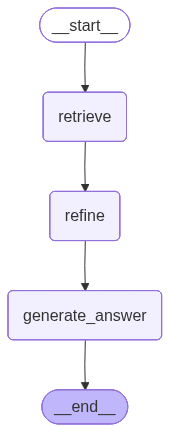

In [53]:
display(Image(rag.get_graph(xray=1).draw_mermaid_png()))

In [54]:
res = rag.invoke({
    "question": "Explain the bias–variance tradeoff",
    "docs": [],
    "strips": [],
    "kept_strips": [],
    "refined_context": "",
    "answer": ""
})

In [55]:
res.keys()

dict_keys(['question', 'docs', 'strips', 'kept_strips', 'refined_context', 'answer'])

In [56]:
res["refined_context"]

'5.4.4 TradingoﬀBiasandVariancetoMinimize MeanSquared Error Bias and variance measure two diﬀerent sources of error in an estimator.\nBias measures the expected deviation from the true value of the function or parameter.\nWhat happens when we are given a choice between two estimators, one with more bias and one with more variance?\nFor example, imagine that we are interested in approximating the function shown in ﬁgure and we are only oﬀered the choice between a model with large bias and5.2 one that suﬀers from large variance.\nThe Bias/Variance Tradeoff An importan t theoretical result of statistics and Machine Learning is the fact that a model’s generaliza tion error can be expressed as the sum of three very different errors: Bias This part of the generalization error is due to wrong assumptions, such as assum‐ ing that the data is linear when it is actually quadratic.\nA high-bias model is most likely to underfit the training data.10 Variance This part is due to the model’s excessiv

In [57]:
display(Markdown(res["answer"]))

The bias–variance tradeoff is a fundamental concept in statistics and machine learning that describes the relationship between bias, variance, and the generalization error of a model. 

- Bias measures the expected deviation from the true value of the function or parameter, often leading to underfitting when high.
- Variance measures the model's sensitivity to small variations in the training data, often leading to overfitting when high.
- The generalization error can be expressed as the sum of bias, variance, and a constant noise term.
- There is a trade-off: flexible models have low bias and high variance, while rigid models have high bias and low variance.
- The optimal model achieves the best balance between bias and variance.
- Increasing model complexity typically increases variance and reduces bias, while reducing complexity increases bias and reduces variance.